In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [37]:
result_mines = []

mxi = -1

for _, row in dataset.iterrows():
    mean_val = row[0:50].mean()
    std_val = row.std()
    thr = mean_val - 3 * std_val
    i_max = row.argmin()
    
    i = 0
    while i + i_max < len(row) and row.iloc[i+i_max] <= thr:
        i += 1
    
    mxi = max(i, mxi)
    segment = row.iloc[i_max:i].values
    result_mines.append(i_max)

data = []
for idx, row in dataset.iterrows():
    data.append(row.iloc[result_mines[idx]:result_mines[idx]+mxi].values)

data = pd.DataFrame(data)
    

In [38]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,14291,14378,14460,14532,14607,14630,14681,14732,14741,14748,14756,14772
1,12921,13039,13388,13752,14056,14273,14426,14536,14620,14673,14700,14736
2,12264,12780,13324,13759,14102,14292,14452,14536,14621,14630,14688,14688
3,14258,14297,14360,14479,14574,14636,14668,14700,14740,14763,14772,14779
4,13028,13194,13498,13875,14161,14356,14487,14571,14609,14646,14712,14747


In [39]:
data.isnull().sum() / len(data) * 100

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
dtype: float64

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

In [41]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=5)
labels = dbscan.fit_predict(X_scaled)
labels = np.where(labels == -1, np.max(labels[labels != -1]) + 1, labels)
np.unique(labels)

array([0, 1, 2])

In [42]:
pd.DataFrame({'cluster': labels}).to_csv('subRawDataDBSCAN.csv', index_label='index')

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
pd.DataFrame({'cluster': kmeans_labels}).to_csv('subRawDataKMeans.csv', index_label='index')

In [44]:
data = (2**14-dataset.T-1560)[140:200].T
data.head()

,140,141,142,143,144,145,146,147,148,149,...,190,191,192,193,194,195,196,197,198,199
0,6,1,6,6,4,10,61,261,446,533,...,25,22,20,13,12,21,21,12,8,5
1,4,4,0,1,5,5,12,151,644,1389,...,4,11,8,14,12,11,7,14,7,8
2,6,-1,-4,5,12,14,42,266,937,1883,...,12,14,17,15,21,12,9,13,13,11
3,4,-3,5,8,4,0,44,194,397,566,...,5,-1,4,6,12,3,4,8,7,4
4,1,2,4,4,0,10,34,193,820,1528,...,12,11,7,5,15,10,14,13,6,5


In [45]:
df = pd.DataFrame()
df["volume"] = np.trapezoid(data, dx=1, axis=1)
df["psd"] = np.trapezoid(data.iloc[:, 0:17], dx=1, axis=1)
df["psd"] = (df["volume"] - df["psd"]) / df["volume"]
df["amplitude"] = data.max(axis=1)
df.head()

,volume,psd,amplitude
0,4159.5,0.270826,533
1,11815.0,0.159797,1903
2,16414.5,0.159402,2560
3,4213.0,0.238310,566
4,11453.0,0.162141,1796


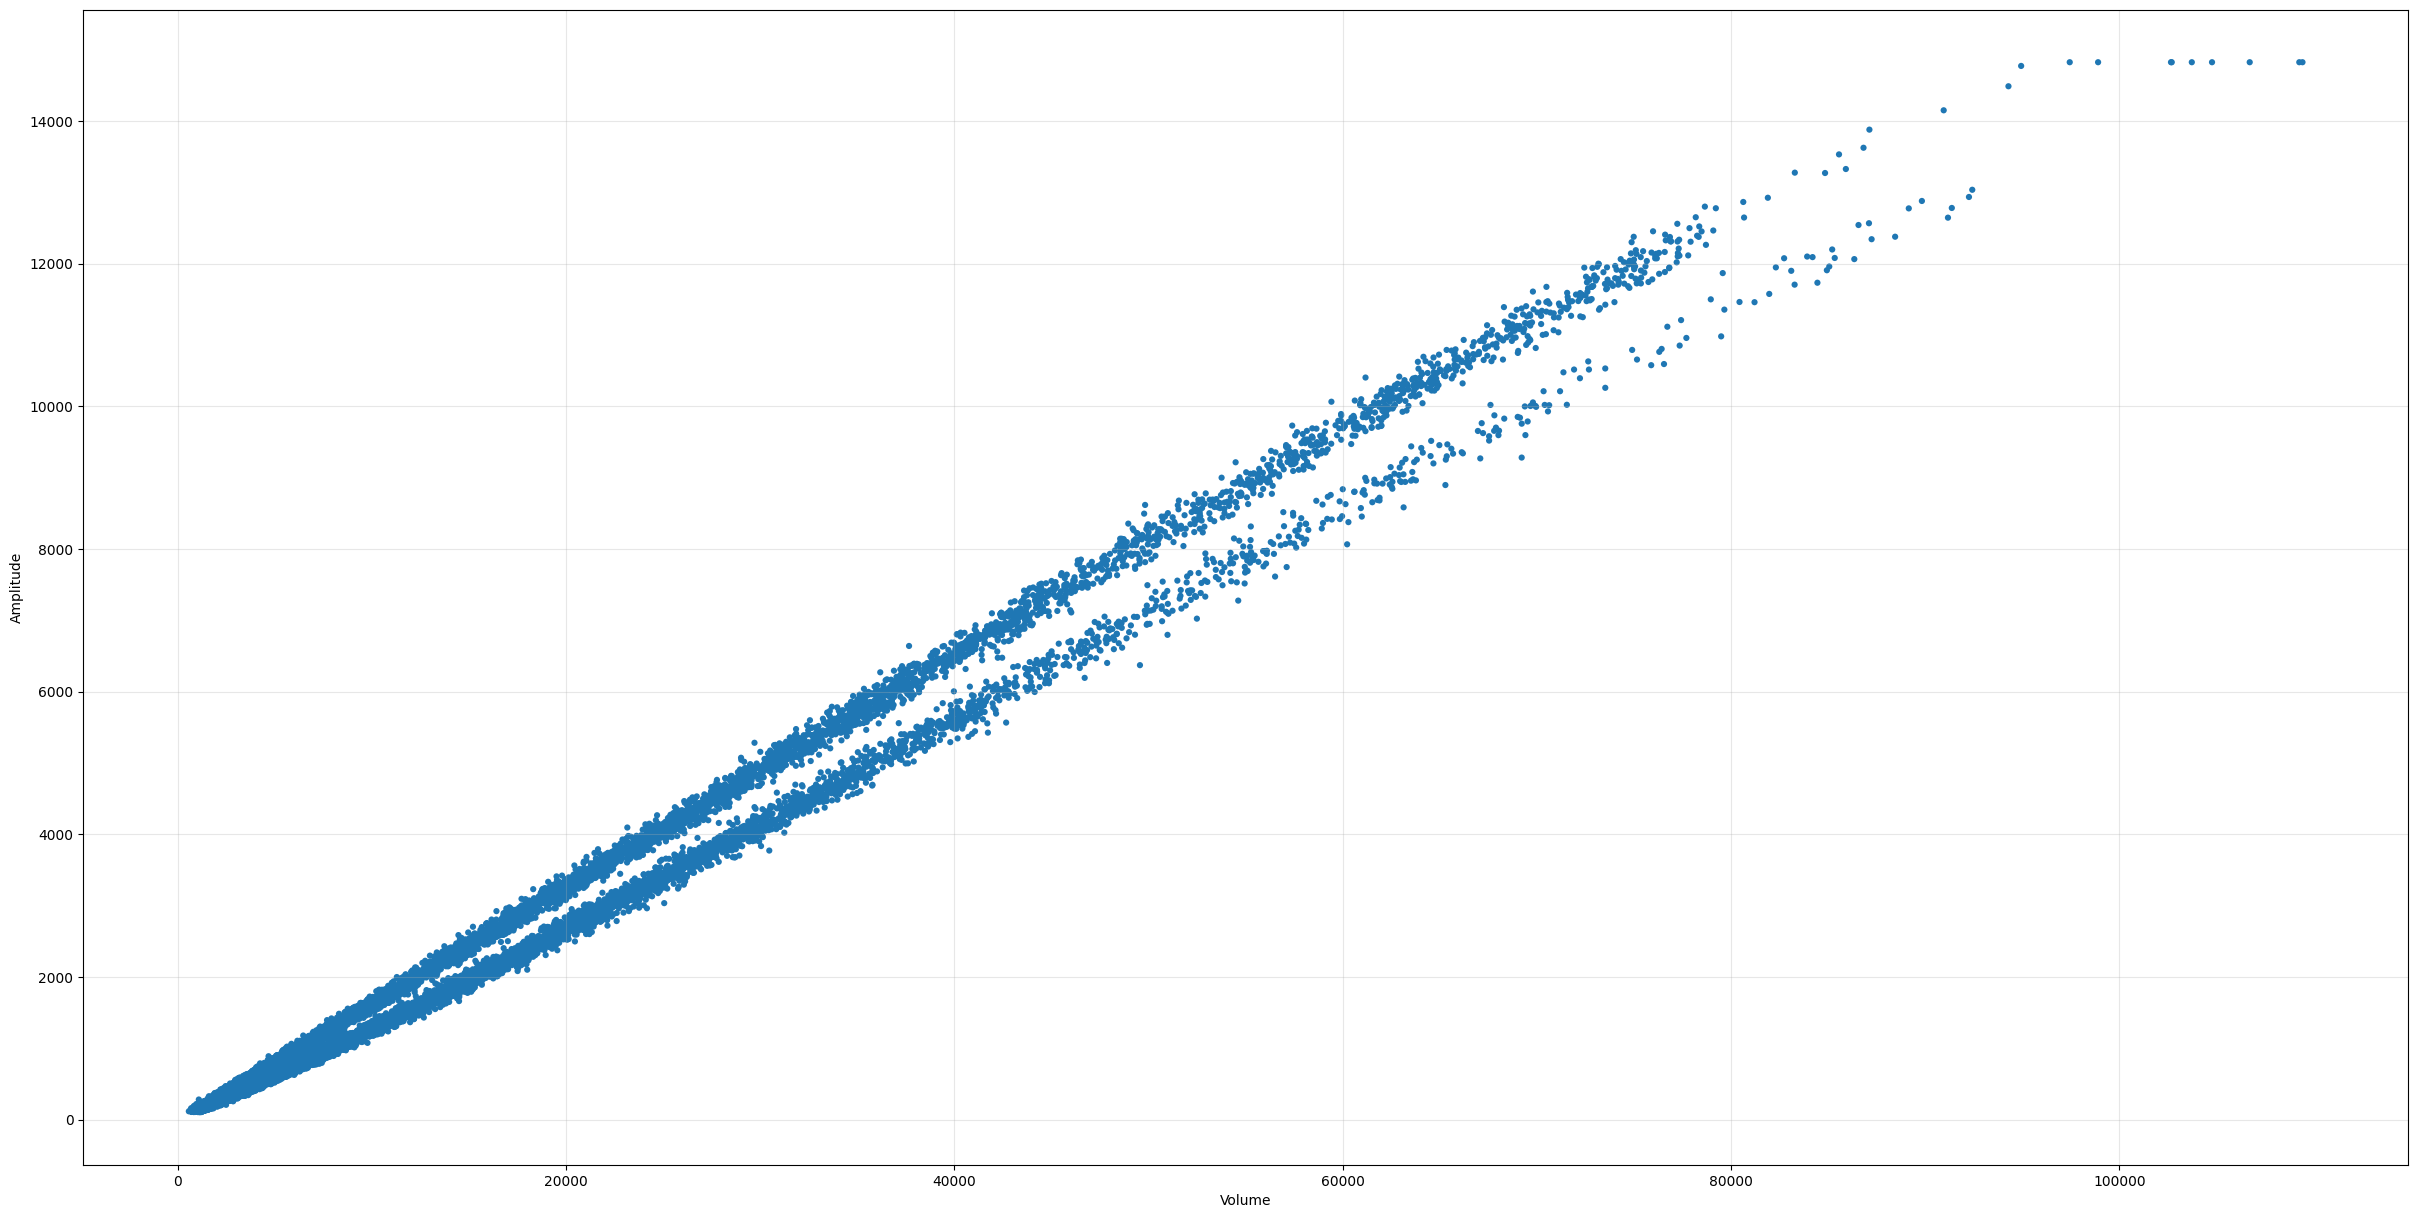

In [46]:
plt.figure(figsize=(30, 15))


plt.scatter(df['volume'], 
            df['amplitude'], 
            s=20,
            edgecolors='none')

plt.xlabel("Volume")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

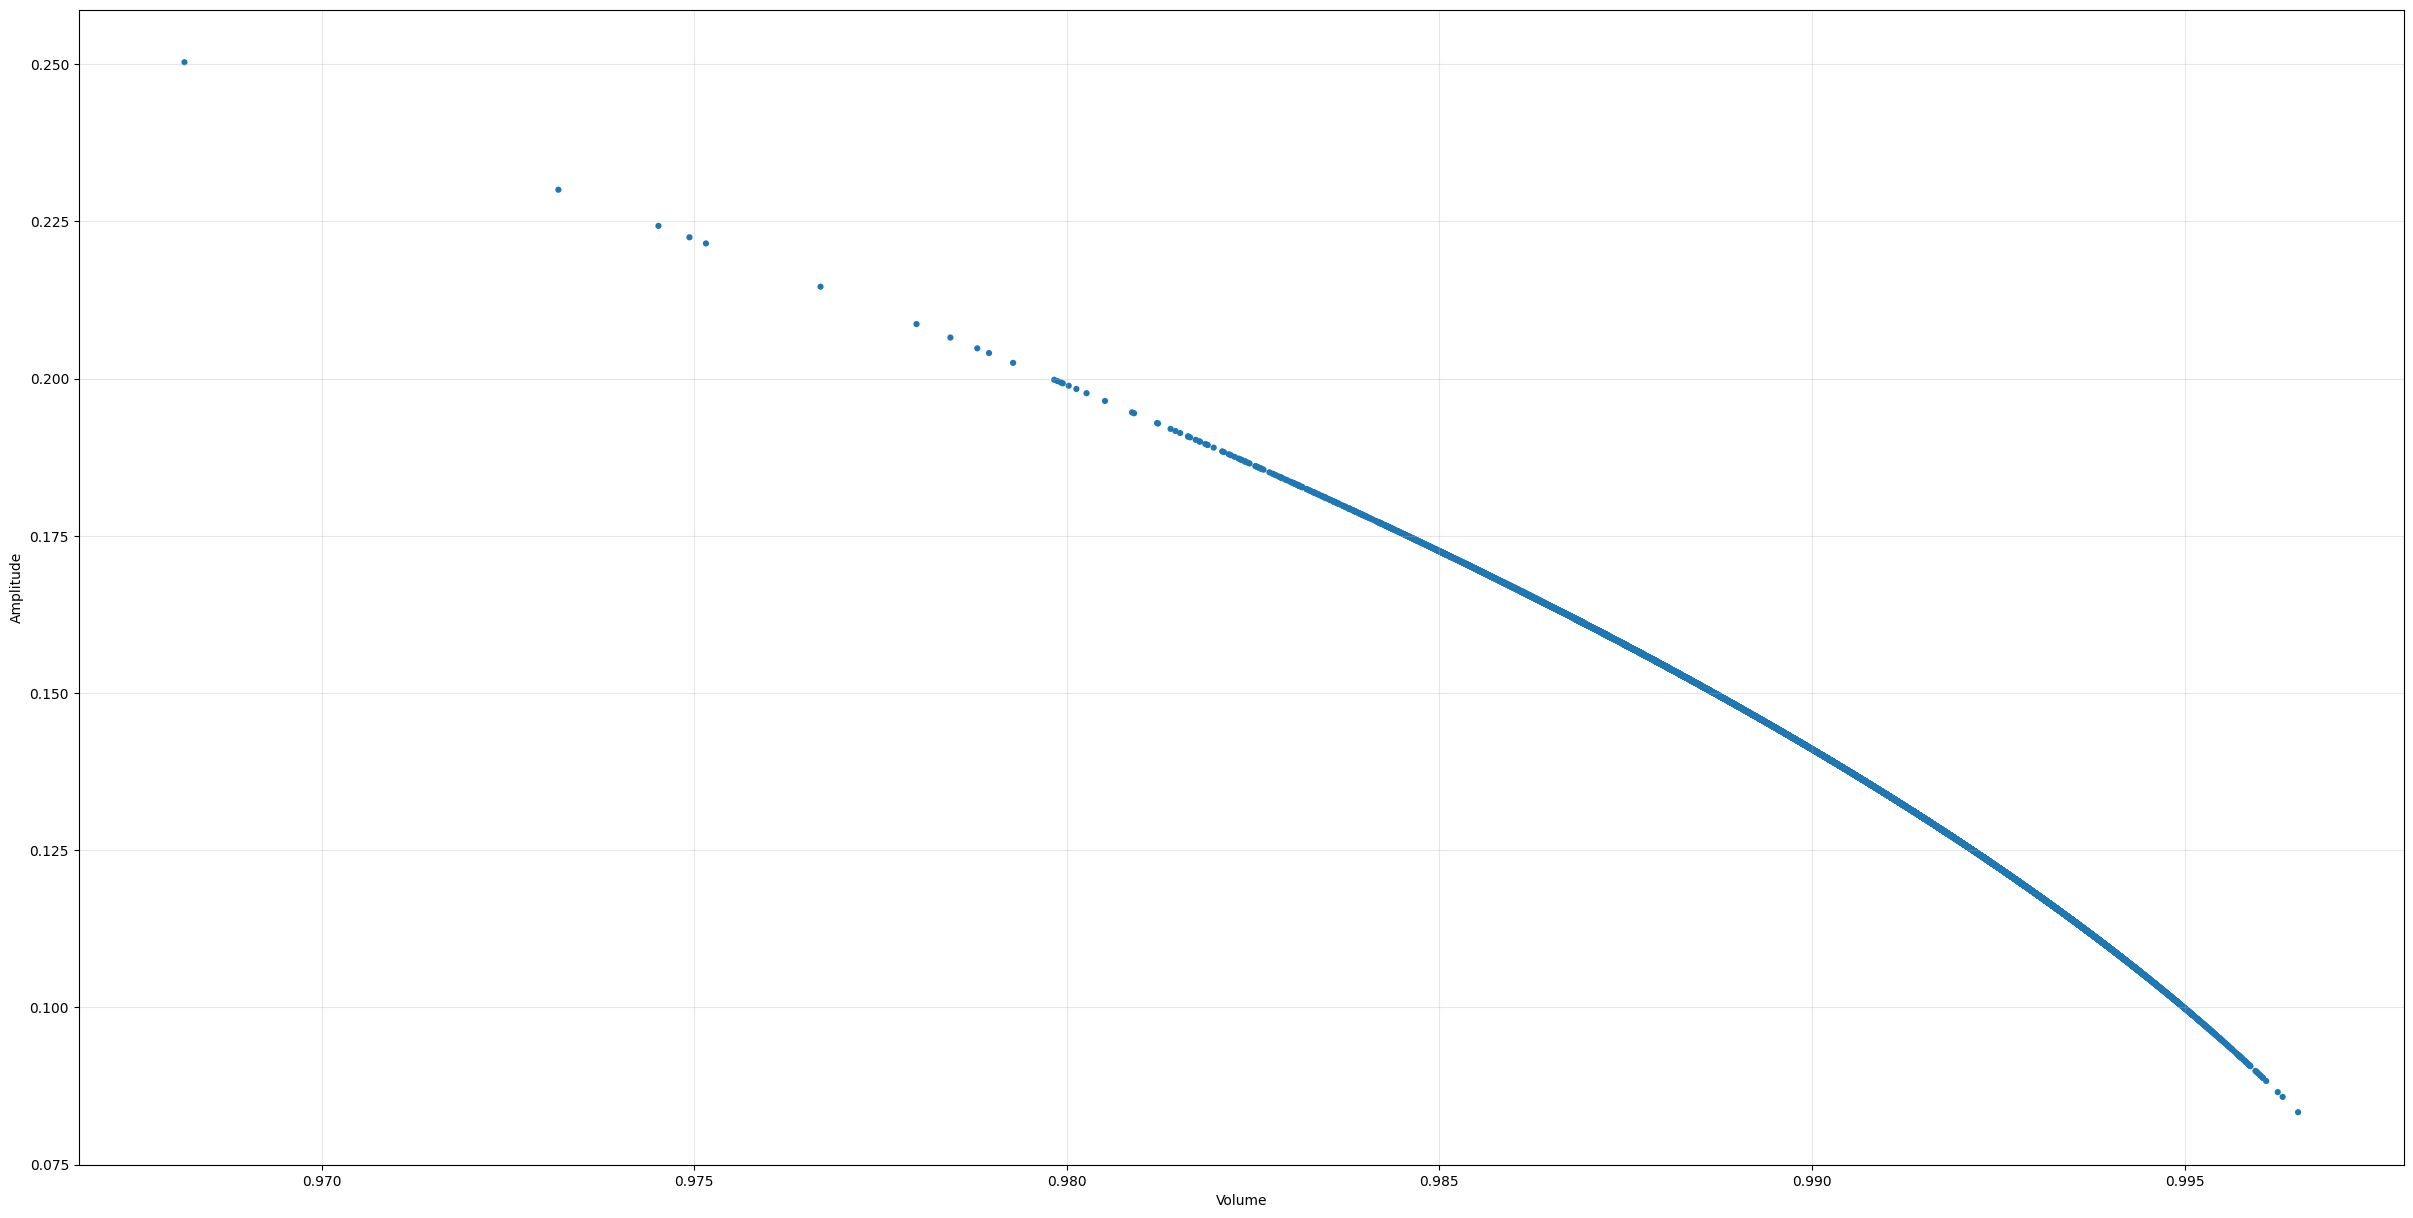

In [47]:
from sklearn.preprocessing import Normalizer

# Нормализуем каждый вектор к единичной длине
normalizer = Normalizer(norm='l2')
X = df[['volume', 'amplitude']]
X_normalized = normalizer.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=['volume', 'amplitude'])
plt.figure(figsize=(30, 15))


plt.scatter(X_normalized['volume'], 
            X_normalized['amplitude'], 
            s=20,
            edgecolors='none')

plt.xlabel("Volume")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
df['phi'] = df['amplitude'] / df['volume']
df.head()

,volume,psd,amplitude,phi
0,4159.5,0.270826,533,0.128140
1,11815.0,0.159797,1903,0.161066
2,16414.5,0.159402,2560,0.155960
3,4213.0,0.238310,566,0.134346
4,11453.0,0.162141,1796,0.156815


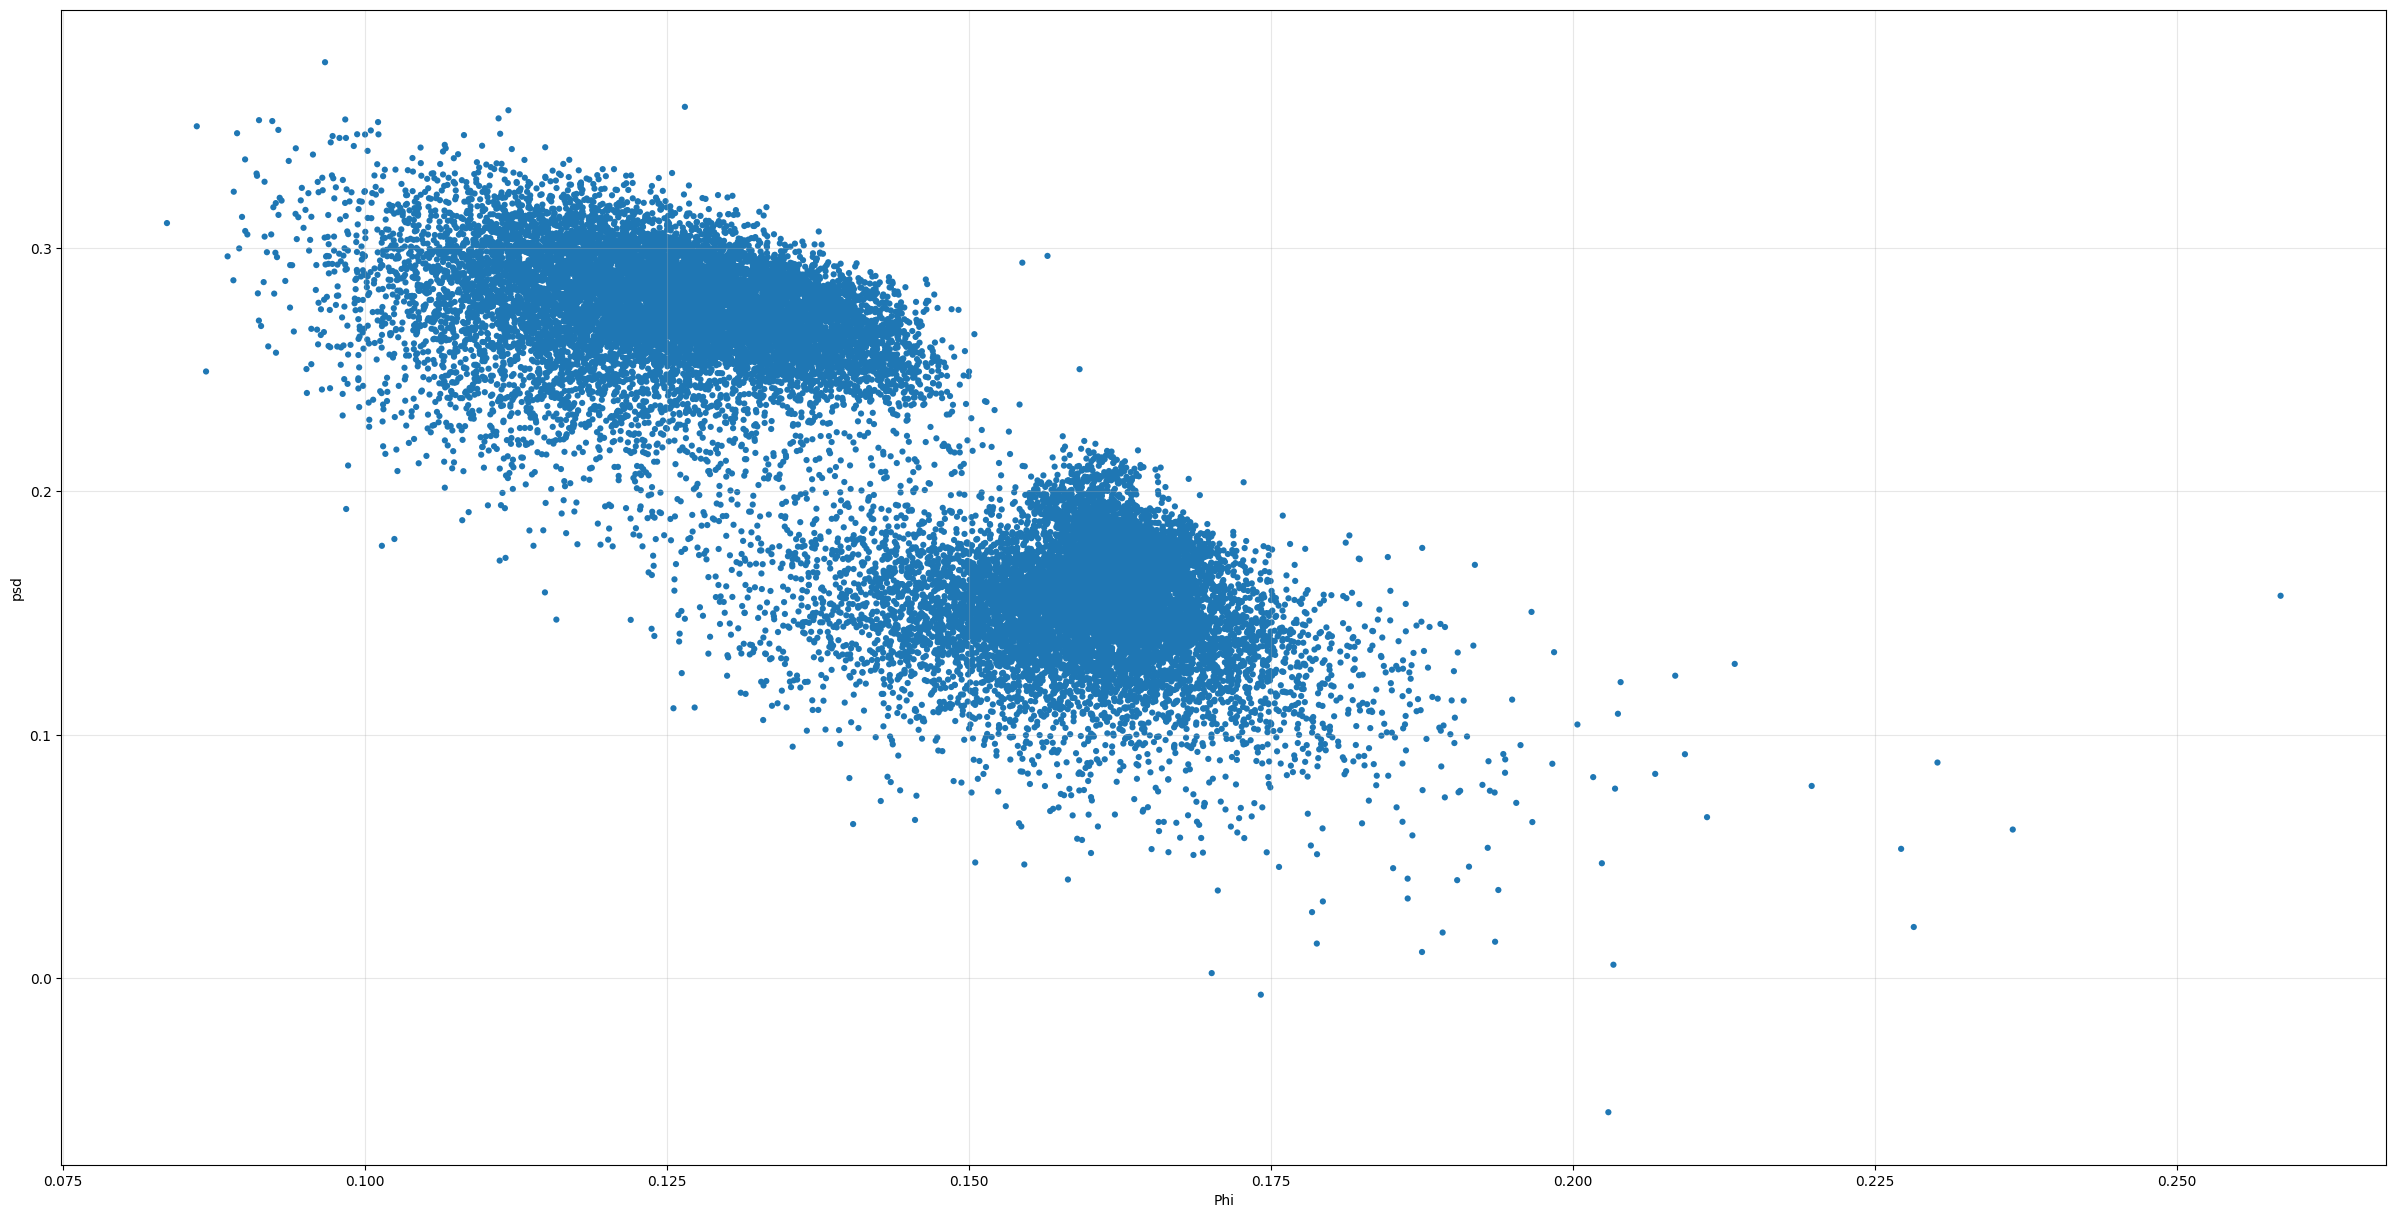

In [49]:
plt.figure(figsize=(30, 15))


plt.scatter(df['phi'], 
            df['psd'], 
            s=20,
            edgecolors='none')

plt.xlabel("Phi")
plt.ylabel("psd")
plt.grid(True, alpha=0.3)
plt.show()

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['phi', 'psd']])
X_scaled = pd.DataFrame(X_scaled, columns=['phi', 'psd'])


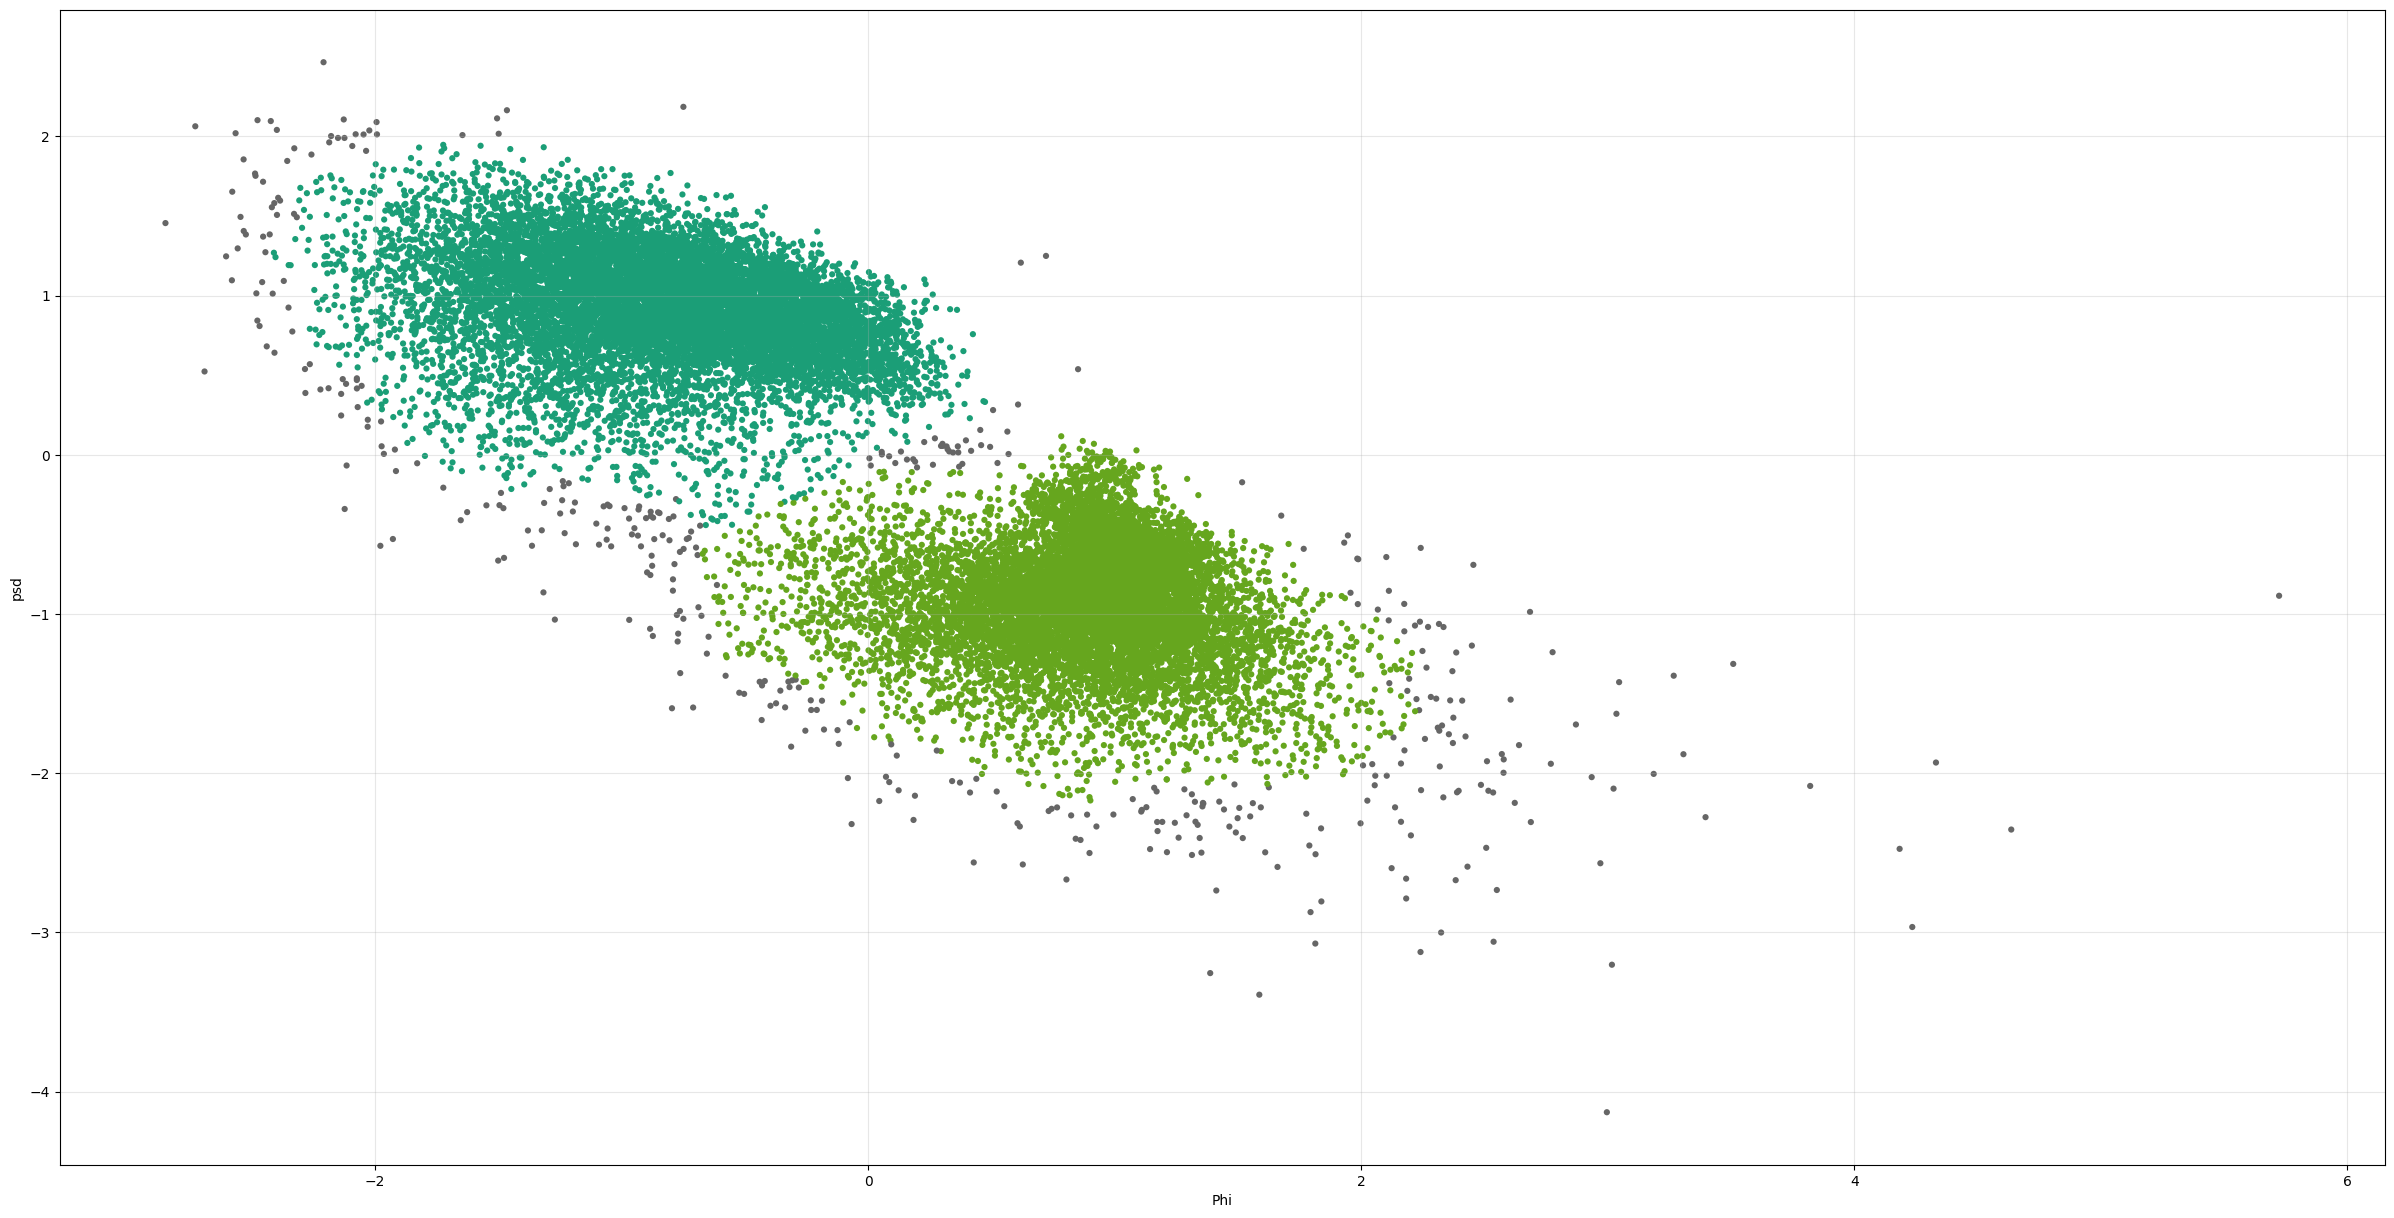

array([0, 1, 2])

In [51]:
dbscan = DBSCAN(eps=0.152, min_samples=25)
labels = dbscan.fit_predict(X_scaled)
labels = np.where(labels == -1, np.max(labels[labels != -1]) + 1, labels)

plt.figure(figsize=(30, 15))


plt.scatter(X_scaled['phi'], 
            X_scaled['psd'],
            c=labels,
            cmap='Dark2',
            s=20,
            edgecolors='none')

plt.xlabel("Phi")
plt.ylabel("psd")
plt.grid(True, alpha=0.3)
plt.show()
np.unique(labels)

In [52]:
pd.DataFrame({'cluster': labels}).to_csv('subDBSCANPhiPSD.csv', index_label='index')

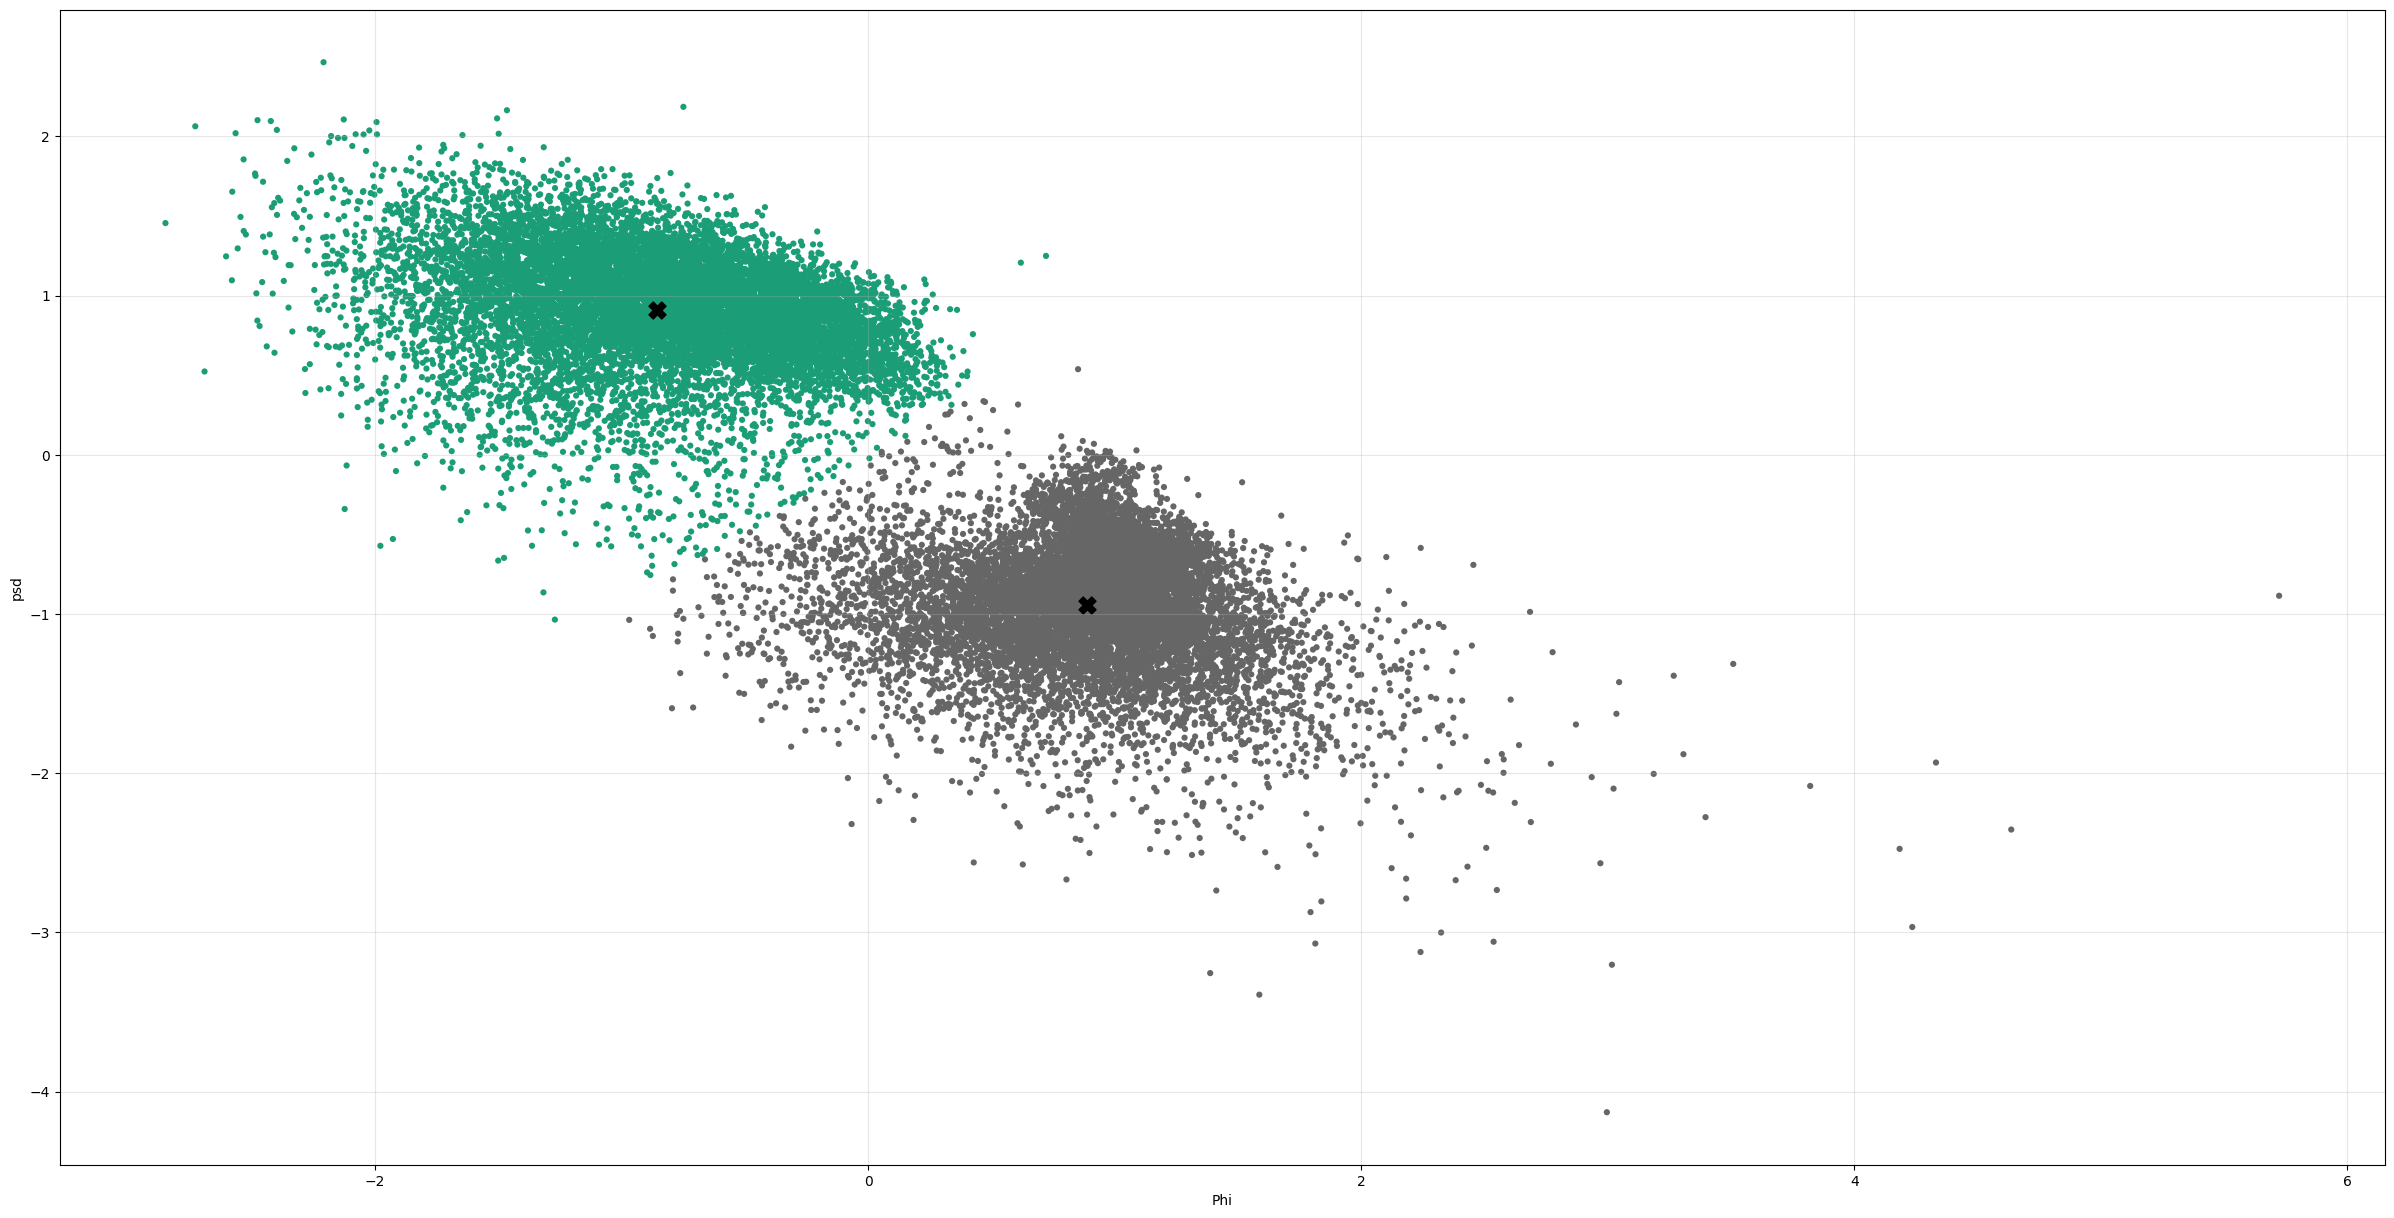

In [53]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
X_scaled["labels"] = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_
plt.figure(figsize=(30, 15))


plt.scatter(X_scaled['phi'], 
            X_scaled['psd'],
            c=X_scaled["labels"],
            cmap='Dark2',
            s=20,
            edgecolors='none')
plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='X', s=150, label='Centroids')

plt.xlabel("Phi")
plt.ylabel("psd")
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
pd.DataFrame({'cluster': X_scaled["labels"]}).to_csv('subKMeansPhiPSD.csv', index_label='index')